# Welcome to Tabular Classification/Regression

## This is the user guide notebook for sampling asset

## According to guide notebooks, find your own arguments.

In [1]:
from wrapping import Wrapper

In [2]:
wrapper = Wrapper(0, exp_plan_file='config/sampling_experimental_plan.yaml')

[2023-11-16 05:06:08,564][PROCESS][INFO]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << ACCESS_KEY, SECRET_KEY >> in your os environment. 

[2023-11-16 05:06:08,567][PROCESS][INFO]:  << train >> already exists in << /home/jovyan/project/alo_test/tcr/alo/input/ >>. 
 & << get_external_data >> is set as << every >>. 
 Start re-loading external data. << /nas001/users/sujin2.lee/share/techtalk_sampling_1030/train/ >> : pre-existing directory is deleted ! 

[2023-11-16 05:06:09,000][PROCESS][INFO]: Start setting-up << input >> asset @ << assets >> directory.
[2023-11-16 05:06:09,004][PROCESS][INFO]: Start renewing asset : /home/jovyan/project/alo_test/tcr/alo/assets/input
[2023-11-16 05:06:09,682][PROCESS][INFO]: /home/jovyan/project/alo_test/tcr/alo/assets/input successfully pulled.
[2023-11-16 05:06:09,686][PROCESS][INFO]: Start set

  You can safely remove it manually.
  You can safely remove it manually.


[2023-11-16 05:06:29,305][PROCESS][INFO]: ======================================== Finish dependency installation 



In [3]:
wrapper.run()
data_input = wrapper.data
y_column = wrapper.args['y_column']

[2023-11-16 05:06:29,352][USER][INFO][train_pipeline][input]: >> Load path : ['/home/jovyan/project/alo_test/tcr/alo/input/train/train/']


[2023-11-16 05:06:29,347][ASSET][INFO][train_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-16 05:06:29
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])




[2023-11-16 05:06:30,154][USER][INFO][train_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/project/alo_test/tcr/alo/input/train/train/train.csv)
[2023-11-16 05:06:30,179][USER][INFO][train_pipeline][input]: ==================== Success loading dataframe ====================
[2023-11-16 05:06:30,183][USER][INFO][train_pipeline][input]: >> Drop columns from the input dataframe when set << auto >> mode or specified in the << drop_columns >> in config yaml. (dropped colums:[])
[2023-11-16 05:06:30,186][USER][INFO][train_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/project/alo_test/tcr/alo/input/train/train/train.csv']


[2023-11-16 05:06:30,193][ASSET][INFO][train_pipeline][input]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-16 05:06:30
- current step      : input
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns'])
- save data keys    : dict_keys(['dataframe'])


[2023-11-16 05:06:30,196][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: input


## 불균등 유형 분포를 가진 샘플 데이터를 이용해서 샘플링 asset argument 설정 방법을 학습해봅니다.

### Sample Data 구성

- boltfastening dataset
- 경로: /nas001/users/sujin2.lee/share/techtalk_sampling_1030/train/
- x_columns: 13개 (Count,Converted, Torque,angle_min,angle_mean,angle_median,angle_std,angle_max,torque_min,torque_mean,torque_median,torque_std,torque_max)
- y_column: label
- 총 데이터 수: 10100

#### label 별 데이터 수

In [4]:
data_input['dataframe'][y_column].value_counts()

OK    10000
NG      100
Name: label, dtype: int64

#### groupkey 별 데이터 수

In [39]:
data_input['dataframe']['groupkey'].value_counts()

g3    3535
g2    3535
g1    3030
Name: groupkey, dtype: int64

#### label 및 groupkey 별 데이터 수

In [37]:
data_input['dataframe'][[y_column, 'groupkey']].value_counts().unstack()

groupkey,g1,g2,g3
label,,,
NG,31,34,35
OK,2999,3501,3500


### Sampling asset 사용법
- sampling asset은 data imbalance를 해결하기 위한 under sampling과 over sampling(TBD) 방법론을 제공합니다.
- sampling asset은 아래와 같은 방식으로 진행됩니다. 
    1. 데이터를 grouping하여 데이터 subgroup을 생성합니다.
        - 데이터의 **라벨**과 **그룹키** 컬럼을 기준으로 데이터를 subgroup으로 나눌 수 있습니다.
        - 하기와 같이 총 네 가지 방법으로 subgroup을 나눈 후 샘플링을 적용할 수 있습니다.
            1. subgroup을 생성하지 않고 전체 데이터에 대해 샘플링 적용하기
            2. **라벨**로 subgroup 생성하기(label subgrouping)
            3. **그룹키**로 subgroup 생성하기(groupkey subgrouping)
            4. **라벨**과 **그룹키** 모두 사용하여 subgroup 생성하기
        - 아래는 **라벨**과 **그룹키** 컬럼 모두 사용하여 subgroup을 나눈 예시입니다.  

<div style='text-align:center'><img src="src/techtalk_sampling.PNG" width="500" height="500"/></div>
        
    2. 각 데이터 subgroup에 sampling 방법론을 적용합니다.

### Sampling asset argument list

argument가 다소 복잡하지만 아래 Exercise를 따라하면 쉽게 설정할 수 있습니다.

|args|explanation|default|example|data type|necessary|
|:---:|:---:|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형 선택 |none(asset 사용x)|none, under, over(TBD)|str|yes|
|sampling_method|under sampling 방법론 선택|random|random, cluster, negative|str|no|
|label_sampling|label subgrouping 진행 여부|False(기능 사용x)|True, False|boolean|yes(label subgroup 사용 시)|
|ignore_label_class|특정 유형 데이터를 모두 데이터에 포함시켜야 하는 경우 지정|\[\]|OK, NG 등 라벨 명 입력|str|yes(label subgroup 사용 시)|
|negative_target_class|(수정필요)| |(수정필요)|(수정필요)|yes(negative sampling 사용 시)|
|label_sampling_num_type|label subgrouping 사용 시 샘플링 데이터 수를 결정하는 방법을 지정합니다.|ratio|ratio,number,mingroup|str|yes(label subgroup 사용 시)|
|label_sampling_num|label_sampling_num_type에 맞춰서 적합한 인자를 입력합니다|0.8|아래 sampling 데이터 수 지정 참고|float,int,dict|yes(label subgroup 사용 시)|
|sampling_groupkey_columns|그룹키로 지정할 컬럼을 입력합니다.(3개 까지 가능)|\[\]|\[컬럼1, 컬럼2\]|list|yes(groupkey subgroup 사용 시)|
|sampling_num_type|groupkey subgrouping 사용 시 샘플링 데이터 수를 결정하는 방법을 지정합니다.|ratio|ratio,number,mingroup|str|yes(groupkey subgroup 사용 시)|
|sampling_num|sampling_num_type에 맞춰서 적합한 인자를 입력합니다|0.8|아래 sampling 데이터 수 지정 참고|float,int,dict|yes(groupkey subgroup 사용 시)|

#### sampling_method

현재 sampling asset에서 제공하는 방법론은 `random`, `cluster`, `negative`의 세 가지입니다. `random`은 데이터 수가 많아 임의 추출하고 싶은 경우, `cluster`는 input data의 분포에 따라 골고루 추출하고 싶은 경우, `negative`는 binary classification인 경우에 사용이 가능하며 특정 유형의 대표성이 부족한 경우(수정필요) 수행하게 됩니다.

#### sampling 데이터 수 지정 방법

sampling asset에서는 label이나 groupkey에 따라 subgrouping을 할 수 있습니다. 이 때 각 방법에 대해 sampling 데이터 수를 결정하는 방법에 대해 지정하여 데이터 불균등 문제를 좀 더 심도있게 다룰 수 있습니다. 우선 sampling 데이터 수를 결정하는 방법(`sampling_num_type`)을 선택하고 이에 따라 데이터 수나 비율에 해당하는 `sampling_num`를 하단 표에 따라 설정하면 됩니다.

##### groupkey subgrouping의 경우
|index|sampling_num_type|sampling_num 예시|설명|range|data type|
|:---:|:---:|:---:|:---:|:---:|:---:|
|1|ratio|0.8|입력한 비율에 맞춰서 데이터 추출|0~1|float|
|2|number|500|입력한 숫자(데이터 수)만큼 데이터 추출|1<|int|
|3|mingroup| |subgroup 중에서 가장 크기가 작은 subgroup 기준으로 샘플링|-|-|

##### label subgrouping의 경우
|index|label_sampling_num_type|label_sampling_num 예시|설명|range|data type|
|:---:|:---:|:---:|:---:|:---:|:---:|
|1|ratio|0.8|입력한 비율에 맞춰서 데이터 추출|0~1|float|
|2|number|500|입력한 숫자(데이터 수)만큼 데이터 추출|1<|int|
|3|mingroup| |subgroup 중에서 가장 크기가 작은 subgroup 기준으로 샘플링|-|-|
|4|compare|{}|유형 별 데이터를 입력한 값으로 비례하게 샘플링| {NG:1, OK:10} |dict|

### Exercise
#### A. 데이터 전체에 sampling 적용하기
- 데이터 subgroup 생성 없이 전체 데이터에 대해 under sampling을 적용합니다.
- 변경해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|sampling_num_type|샘플링 데이터 수를 결정하는 방법을 지정합니다.|ratio|ratio,number,mingroup|
|sampling_num|sampling_num_type에 맞춰서 적합한 인자를 입력합니다|0.8|아래 sampling 데이터 수 지정 참고|  
- 아래는 subgroup 생성 없이 전체 데이터에 대해 random sampling을 적용하는 예제입니다.
- random sampling은 임의 추출하는 방법이고 아래 예시에서는 데이터 구분없이 0.8 비율로 추출했습니다.
- sampling_args['argument 명'] = '값'을 입력하여 sampling asset의 arguments를 입력합니다.

In [5]:
sampling_args = wrapper.get_args(step=1)
sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'random'
sampling_args['sampling_num_type'] = 'ratio'
sampling_args['sampling_num'] = 0.8

In [6]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'random',
 'label_sampling': False,
 'ignore_label_class': None,
 'negative_target_class': None,
 'label_sampling_num_type': None,
 'label_sampling_num': None,
 'sampling_groupkey_columns': None,
 'sampling_num_type': 'ratio',
 'sampling_num': 0.8}

- sampling asset을 구동합니다

In [7]:
wrapper.run(args=sampling_args)
data_sampling = wrapper.data

/home/jovyan/conda/envs/tcr_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-16 05:06:35,995][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-16 05:06:35
- current step      : sampling
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['sampling_type', 'sampling_method', 'label_sampling', 'ignore_label_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns'])
- load data ke

/home/jovyan/project/alo_test/tcr/alo/assets/sampling/asset_sampling.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


#### input data와 sampling 한 후 data shape 비교

- 앞서 설정한 것처럼 80% 데이터가 추출되었습니다.

In [8]:
data_input['dataframe'].shape

(10100, 36)

In [9]:
data_sampling['dataframe'].shape

(8080, 37)

#### B. label(y_column) 기준으로 데이터 subgroup 나누어 sampling 적용하기
- 라벨 기준으로 subgroup을 생성하여 각 라벨 데이터에 under sampling을 적용할 때 조정해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|label_sampling|label sampling 진행 여부를 선택합니다.|False(기능 사용x)|True, False|
|ignore_label_class|특정 클래스에 대해 샘플링하지 않을 경우 지정합니다.|-|클래스 명 입력|  
|label_sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|label_sampling_num|label_sampling_num_type의 인자를 입력합니다.|-|위 sampling 수 지정 참고|
- 아래는 NG라벨은 모두 사용하고, OK라벨 데이터에 대해 NG 데이터 수의 10배만큼 추출하는 예제입니다.
- 하기 예제에서는 cluster sampling 기법을 사용하여 입력 데이터 분포를 고려하여 추출합니다. 

In [10]:
data_input['dataframe'].columns

Index(['Unnamed: 0', 'No', 'Time', 'Ch1', 'Ch2', 'Count', 'Fastening Time',
       'Target Torque', 'Converted Torque', 'Speed', 'A1', 'A2', 'Snug Angle',
       'Error', 'Screws', 'Result', 'Troque', 'Angle', 'label', 'sample_type',
       'file_name', 'Label_FILE', 'path', 'angle_min', 'angle_mean',
       'angle_median', 'angle_std', 'angle_max', 'torque_min', 'torque_mean',
       'torque_median', 'torque_std', 'torque_max', 'ng_type', 'encoded_label',
       'groupkey'],
      dtype='object')

In [11]:
sampling_args = wrapper.get_args(step=1)
sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'cluster'
sampling_args['label_sampling'] = True
sampling_args['ignore_label_class'] = 'NG'
sampling_args['label_sampling_num_type'] = 'compare'
sampling_args['label_sampling_num'] = {'NG':1,'OK':10}
sampling_args['sampling_num'] = 0.8

In [12]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'cluster',
 'label_sampling': True,
 'ignore_label_class': 'NG',
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {'NG': 1, 'OK': 10},
 'sampling_groupkey_columns': None,
 'sampling_num_type': 'ratio',
 'sampling_num': 0.8}

- sampling asset을 구동합니다

[2023-11-16 05:06:36,453][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-16 05:06:36
- current step      : sampling
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['sampling_type', 'sampling_method', 'label_sampling', 'ignore_label_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'sampling_type'

/home/jovyan/project/alo_test/tcr/alo/assets/sampling/asset_sampling.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


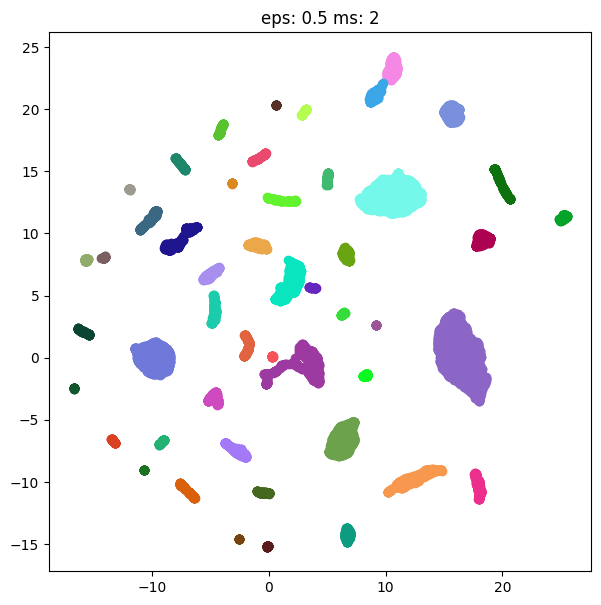

In [13]:
wrapper.run(args=sampling_args, step=1, data=data_input)
data_sampling = wrapper.data

#### input data와 sampling 한 후 data shape 비교

In [14]:
data_input['dataframe'].shape

(10100, 36)

In [15]:
data_sampling['dataframe'].shape

(1100, 37)

In [16]:
data_sampling['dataframe'][y_column].value_counts()

OK    1000
NG     100
Name: label, dtype: int64

#### C. 그룹키 기준으로 데이터 subgroup 나누어 sampling 적용하기
- 그룹키 기준으로 subgroup을 생성하여 각 그룹 데이터에 under sampling을 적용할 때 조정해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|sampling_groupkey_columns|그룹키로 지정할 컬럼을 입력합니다.(3개 까지 가능)|-|컬럼 명 입력|
|sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|sampling_num|sampling_num_type 인자를 입력합니다.|-|위 sampling 수 지정 참고|
- 아래는 그룹키 컬럼을 기준으로 입력한 데이터 수 만큼 random sampling을 진행하는 예제입니다.
- 그룹키 subgroup마다 같은 수 만큼(number) 추출합니다.

In [17]:
sampling_args = wrapper.get_args(step=1)

sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'random'
sampling_args['label_sampling'] = False
sampling_args['sampling_groupkey_columns'] = 'groupkey' # 추후 list로 수정 예정
sampling_args['sampling_num_type'] = 'number'
sampling_args['sampling_num'] = 500

In [18]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'random',
 'label_sampling': False,
 'ignore_label_class': 'NG',
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {'NG': 1, 'OK': 10},
 'sampling_groupkey_columns': 'groupkey',
 'sampling_num_type': 'number',
 'sampling_num': 500}

- sampling asset을 구동합니다

In [19]:
wrapper.run(args=sampling_args, step=1, data=data_input)
data_sampling = wrapper.data

[2023-11-16 05:07:08,864][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-16 05:07:08
- current step      : sampling
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['sampling_type', 'sampling_method', 'label_sampling', 'ignore_label_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'sampling_type'

/home/jovyan/project/alo_test/tcr/alo/assets/sampling/asset_sampling.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


#### input data와 sampling 한 후 data shape 비교

In [20]:
data_input['dataframe'].shape

(10100, 36)

In [21]:
data_input['dataframe']['groupkey'].value_counts()

g3    3535
g2    3535
g1    3030
Name: groupkey, dtype: int64

In [22]:
data_sampling['dataframe'].shape

(1500, 37)

#### groupkey 별로 500개씩 추출

In [23]:
data_sampling['dataframe']['groupkey'].value_counts()

g1    500
g3    500
g2    500
Name: groupkey, dtype: int64

#### D. 라벨과 그룹키 기준으로 데이터 subgroup 나누어 sampling 적용하기
- 라벨과 그룹키 기준으로 subgroup을 생성하여 각 그룹 데이터에 under sampling을 적용할 때 조정해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|label_sampling|label sampling 진행 여부를 선택합니다.|False(기능 사용x)|True, False|
|ignore_label_class|특정 클래스에 대해 샘플링하지 않을 경우 지정합니다.|-|클래스 명 입력|  
|label_sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|label_sampling_num|label_sampling_num_type의 인자를 입력합니다.|-|위 sampling 수 지정 참고|
|sampling_groupkey_columns|그룹키로 지정할 컬럼을 입력합니다.(3개 까지 가능)|-|컬럼 명 입력|
|sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|sampling_num|sampling_num_type 인자를 입력합니다.|-|위 sampling 수 지정 참고|
- 아래는 다음과 같은 룰이 적용된 random sampling 방법 예제입니다. 
    - NG 데이터는 모두 사용하고 OK데이터는 NG데이터의 2배가 되도록 함
    - OK 데이터의 경우 입력된 그룹키 컬럼 중 가장 작은 데이터 수를 가진 그룹키 데이터 수에 맞춰서 동일하게 샘플링을 진행함

In [24]:
sampling_args = wrapper.get_args(step=1)
sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'random'
sampling_args['label_sampling'] = True
sampling_args['ignore_label_class'] = 'NG'
sampling_args['label_sampling_num_type'] = 'compare'
sampling_args['label_sampling_num'] = {'NG':1,'OK':2}
sampling_args['sampling_groupkey_columns'] = 'groupkey'  # 추후 list로 수정 예정
sampling_args['sampling_num_type'] = 'mingroup'

In [25]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'random',
 'label_sampling': True,
 'ignore_label_class': 'NG',
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {'NG': 1, 'OK': 2},
 'sampling_groupkey_columns': 'groupkey',
 'sampling_num_type': 'mingroup',
 'sampling_num': 500}

- sampling asset을 구동합니다

In [26]:
wrapper.run(args=sampling_args, step=1, data=data_input)
data_sampling = wrapper.data

[2023-11-16 05:07:09,028][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-16 05:07:09
- current step      : sampling
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['sampling_type', 'sampling_method', 'label_sampling', 'ignore_label_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'sampling_type'

/home/jovyan/project/alo_test/tcr/alo/assets/sampling/asset_sampling.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


sampling process done 0.00334 sec
sampling asset 종료
[2023-11-16 05:07:09,078][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-16 05:07:09
- current step      : sampling
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'sampling_type', 'sampling_method', 'label_sampling', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num', 'ignore_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num'])
- save data keys    : dict_keys(['dataframe'])


[2023-11-16 05:07:09,080][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: sampling


#### input data와 sampling 한 후 data shape 비교

In [27]:
data_input['dataframe'].shape

(10100, 36)

In [28]:
data_input['dataframe'][[y_column,'groupkey']].value_counts()

label  groupkey
OK     g2          3501
       g3          3500
       g1          2999
NG     g3            35
       g2            34
       g1            31
dtype: int64

In [29]:
data_sampling['dataframe'].shape

(301, 37)

OK가 NG의 2배 만큼 샘플링

In [33]:
data_sampling['dataframe'][y_column].value_counts()

OK    201
NG    100
Name: label, dtype: int64

OK의 groupkey의 최소 데이터 수는 충분히 많기 때문에 각 groupkey 별로 균등 샘플링 수행

In [30]:
data_sampling['dataframe'][[y_column,'groupkey']].value_counts()

label  groupkey
OK     g1          67
       g2          67
       g3          67
NG     g3          35
       g2          34
       g1          31
dtype: int64

[2023-11-16 05:07:09,752][ASSET][INFO][train_pipeline][train]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/project/alo_test/tcr/alo/.train_artifacts/models/train/
[2023-11-16 05:07:09,755][ASSET][INFO][train_pipeline][train]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/project/alo_test/tcr/alo/.train_artifacts/output/train/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2023-11-16 05:07:09,756][ASSET][INFO][train_pipeline][train]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-16 05:07:09
- current step      : train
- asset branch.     : main
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_pat


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] 0th-fold RandomForestClassifier_set0 모델을 학습합니다.(1/36)
[INFO] 1th-fold RandomForestClassifier_set0 모델을 학습합니다.(2/36)
[INFO] 2th-fold RandomForestClassifier_set0 모델을 학습합니다.(3/36)
[INFO] 3th-fold RandomForestClassifier_set0 모델을 학습합니다.(4/36)
[INFO] 0th-fold RandomForestClassifier_set1 모델을 학습합니다.(5/36)
[INFO] 1th-fold RandomForestClassifier_set1 모델을 학습합니다.(6/36)
[INFO] 2th-fold RandomForestClassifier_set1 모델을 학습합니다.(7/36)
[INFO] 3th-fold RandomForestClassifier_set1 모델을 학습합니다.(8/36)
[INFO] 0th-fold RandomForestClassifier_set2 모델을 학습합니다.(9/36)
[INFO] 1th-fold RandomForestClassifier_set2 모델을 학습합니다.(10/36)
[INFO] 2th-fold RandomForestClassifier_set2 모델을 학습합니다.(11/36)
[INFO] 3th-fold RandomForestClassifier_set2 모델을 학습합니다.(12/36)
[INFO] 0th-fold LGBMClassifier_set0 모델을 학습합니다.(13/36)
[INFO] 1th-fold LGBMClassifier_set0 모델을 학습합니다.(14/36)
[INFO] 2th-fold LGBMClassifier_set0 모델을 학습합니다.(15/36)
[INFO] 3th-fold LGBMClassifier_set0 모델을 학습합니다.(16/36)
[INFO] 0th-fold LGBMClassifier_set1 모델을 학습합니다.(17

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/project/alo_test/tcr/alo/.train_artifacts/models/train/model_selection.json)

Top 1 model file is saved: /home/jovyan/project/alo_test/tcr/alo/.train_artifacts/models/train/best_model_top0.pkl
[Score] accuracy: 0.9734
[Hyper-parameters] n_estimators: 500, max_depth: 9, n_jobs: 1, num_leaves: 30, verbose: -1, 

Top 2 model file is saved: /home/jovyan/project/alo_test/tcr/alo/.train_artifacts/models/train/best_model_top1.pkl
[Score] accuracy: 0.9668
[Hyper-parameters] n_estimators: 300, max_depth: 7, n_jobs: 1, num_leaves: 30, verbose: -1, 

Top 3 model file is saved: /home/jovyan/project/alo_test/tcr/alo/.train_artifacts/models/train/best_model_top2.pkl
[Score] accuracy: 0.9635
[Hyper-parameters] max_depth: 5, n_jobs: 1, num_leaves: 30, verbose: -1, 

Following model is the best: LGBMClassifier_set2 / accuracy:0.9734




LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[INFO] Summary_plot for Train data 를 저장했습니다.

ignore columns와 X로 지정한 데이터 프레임을 합치는 과정중에 에러가 발생했습니다. 확인 부탁드립니다.
[2023-11-16 05:07:14,850][ASSET][INFO][train_pipeline][train]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-16 05:07:14
- current step      : train
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'sampling_type', 'sampling_method', 'label_sampling', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num', 'ignore_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'feature_dict'])
- save data keys    : dict_keys(['dataframe'])


[2023-11-16 05:07:14,852][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: train


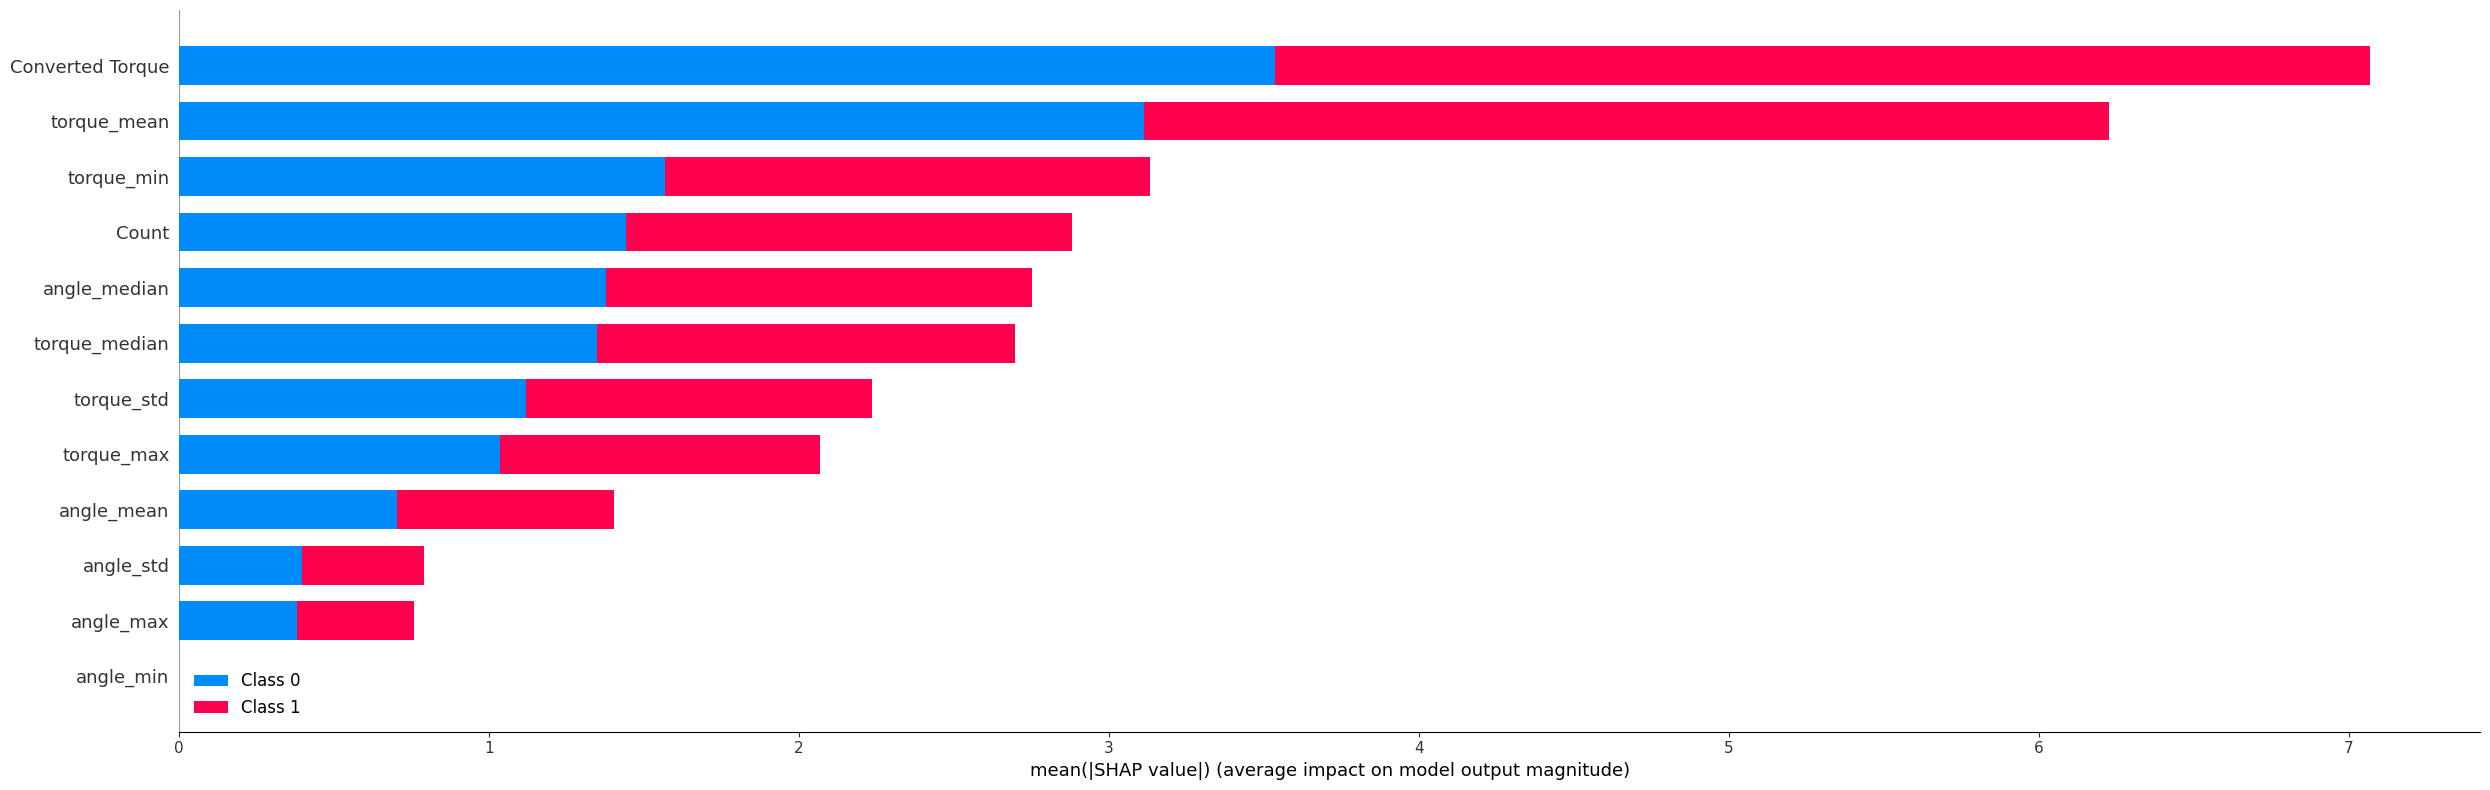

In [31]:
wrapper.run(step=2)

In [32]:
wrapper.data['dataframe']

,Converted Torque,Count,angle_max,angle_mean,angle_median,angle_min,angle_std,torque_max,torque_mean,torque_median,...,torque_min_shapley,torque_std_shapley,label,pred_label,pred_label_best0,pred_label_best1,pred_label_best2,prob_NG,prob_OK,train_test
0,3.50,245.0,1431.0,693.559184,684.0,0.0,487.887769,3.47,0.311959,0.03,...,-1.014498,-1.191836,OK,OK,OK,OK,OK,4.645320e-04,0.999535,2th_test
1,4.01,800.0,5282.0,2270.023750,1958.5,0.0,1688.458274,3.96,0.374188,0.26,...,-1.212855,-1.448509,OK,OK,OK,OK,OK,4.524449e-06,0.999995,2th_test
2,3.50,659.0,5496.0,2987.579666,3180.0,0.0,1674.666554,3.48,0.934992,1.02,...,-2.381206,-0.892638,OK,OK,OK,OK,OK,1.018518e-07,1.000000,3th_test
3,3.51,250.0,1485.0,712.804000,701.0,0.0,502.151983,3.49,0.289880,0.04,...,-0.915664,-1.117409,OK,OK,OK,OK,OK,3.100505e-06,0.999997,0th_test
4,3.51,637.0,5366.0,2903.056515,3102.0,0.0,1633.280375,3.48,0.893485,0.96,...,-1.964336,-0.454253,OK,OK,OK,OK,OK,5.781699e-07,0.999999,1th_test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,4.03,403.0,3188.0,1657.856079,1668.0,0.0,1019.750940,3.99,0.306774,0.02,...,1.317757,-1.948263,OK,OK,OK,OK,OK,1.600154e-04,0.999840,3th_test
297,6.01,474.0,4456.0,2333.767932,2399.0,0.0,1483.544622,5.96,1.047722,0.89,...,0.318018,-1.309977,OK,OK,OK,OK,OK,4.474844e-07,1.000000,1th_test
298,6.02,505.0,4690.0,2529.869307,2651.0,0.0,1546.469187,5.92,0.386891,0.08,...,0.197738,2.782179,NG,OK,OK,OK,OK,4.376997e-05,0.999956,0th_test
299,8.05,650.0,5373.0,3009.230769,3257.5,0.0,1691.789678,7.89,1.704508,1.58,...,-0.392289,1.931131,OK,OK,OK,OK,OK,9.266133e-06,0.999991,0th_test
